In [1]:
import numpy as np # linear algebra

In [2]:
# %cd "Upernet"
%cd "SegFormer-tf"

/home/work2/Workspace/sonnh/do_an_test/SegFormer-tf


In [3]:
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
# from models import upernet_convnext_tiny
from models import SegFormer_B0

2024-06-24 19:23:22.200340: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 19:23:22.220962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 19:23:22.220988: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 19:23:22.220999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 19:23:22.224766: I tensorflow/core/platform/cpu_feature_g

In [4]:
save_train_image_dataset_path = '../bk-isut-dataset/train_image_dataset.npy'
save_val_image_dataset_path = '../bk-isut-dataset/val_image_dataset.npy'
save_test_image_dataset_path = '../bk-isut-dataset/test_image_dataset.npy'
save_train_mask_image_dataset_path = '../bk-isut-dataset/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = '../bk-isut-dataset/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = '../bk-isut-dataset/mask_test_image_dataset.npy'

In [5]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [6]:
# import albumentations as A

In [7]:
os.environ["SM_FRAMEWORK"] = "tf.keras" 
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [8]:
checkpoint_path = "../weights/offline_distill/cp.segformer_student1.h5"

In [9]:
model = SegFormer_B0(input_shape = (256,256,3), num_classes = 5)
# model = upernet_convnext_tiny.UPerNet(input_shape = (256,256,3), num_classes = 5)
# model = sm.FPN('resnet50', classes=5, activation='softmax')
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)

2024-06-24 19:23:23.298457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 19:23:23.301195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 19:23:23.301268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
model.load_weights(checkpoint_path)

2024-06-24 19:23:25.858831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-06-24 19:23:26.165105: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x75568c8114c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-24 19:23:26.165129: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-24 19:23:26.204814: W tensorflow/compiler/xla/service/gpu/buffer_comparator.cc:1052] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-ngoc-Z790-D-DDR4-1d34993e-1485219-61ba1d918394c, line 10; fatal   : Unsupported .version 7.8; current version is '7.5'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only 

1/1 [==============================] - 0s 22ms/step


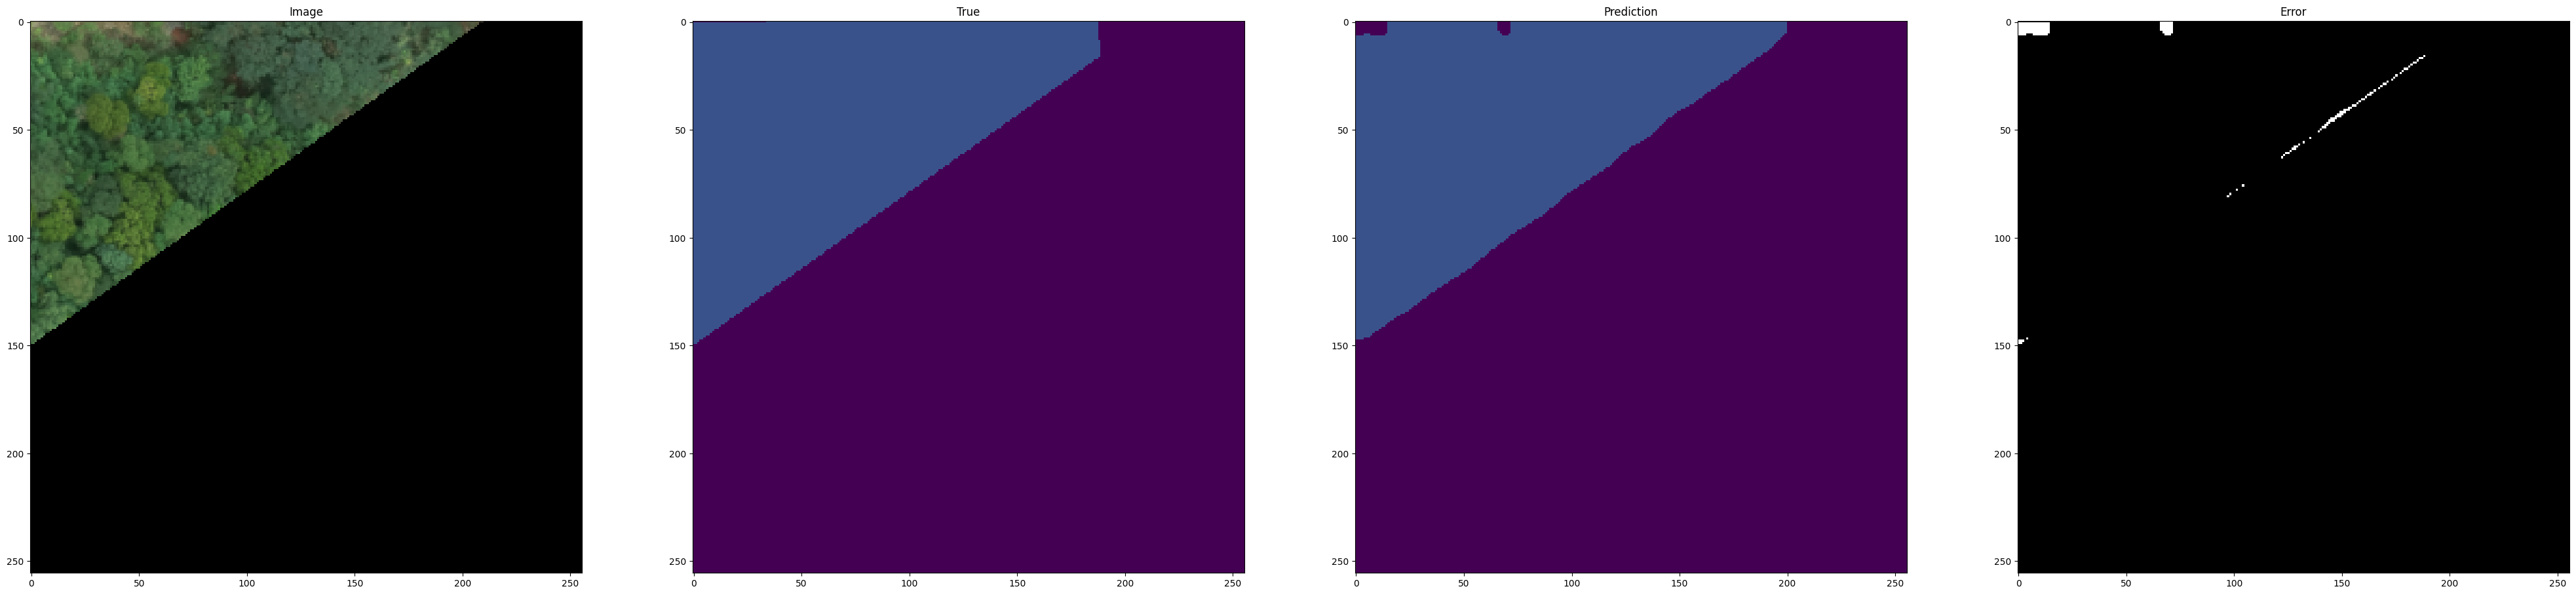

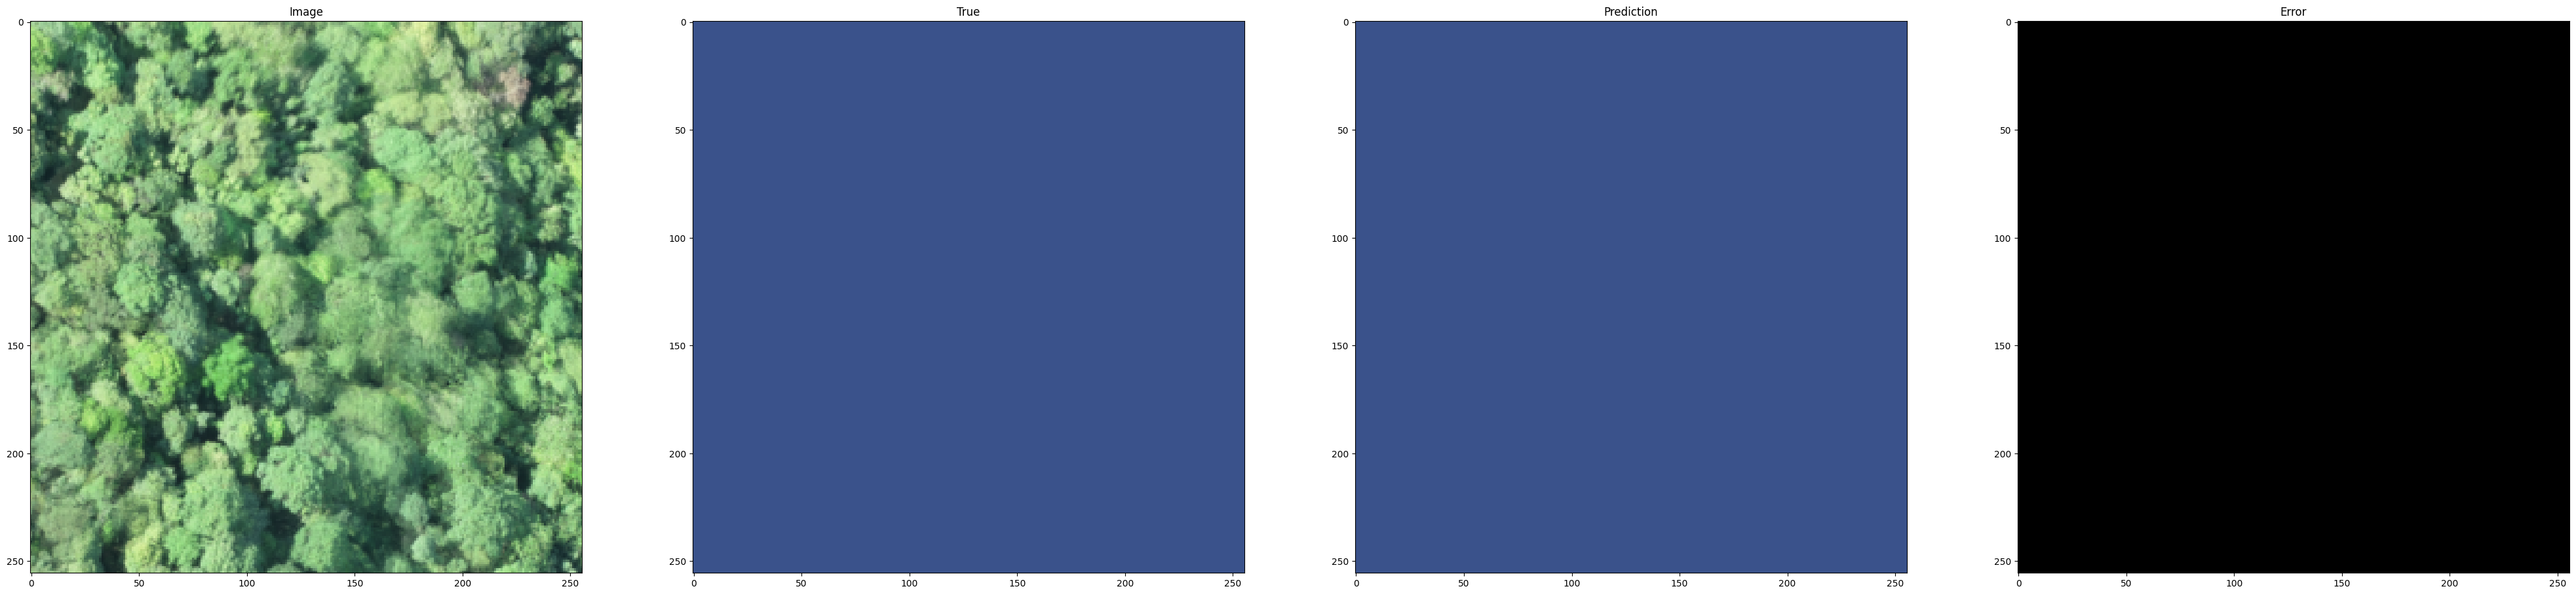

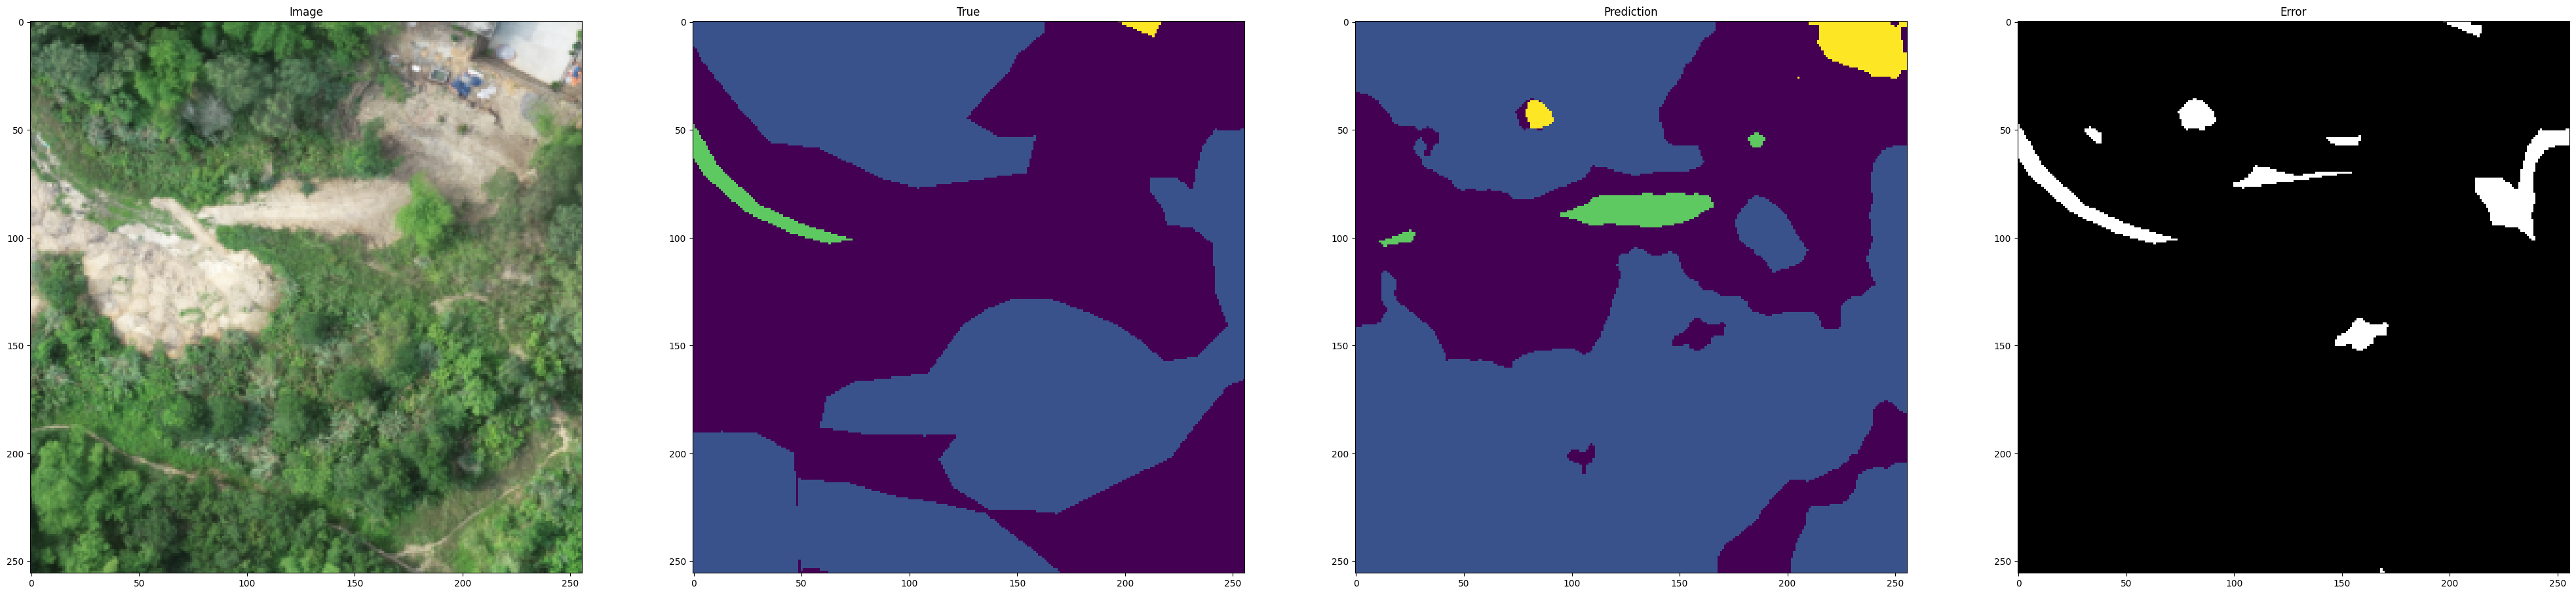

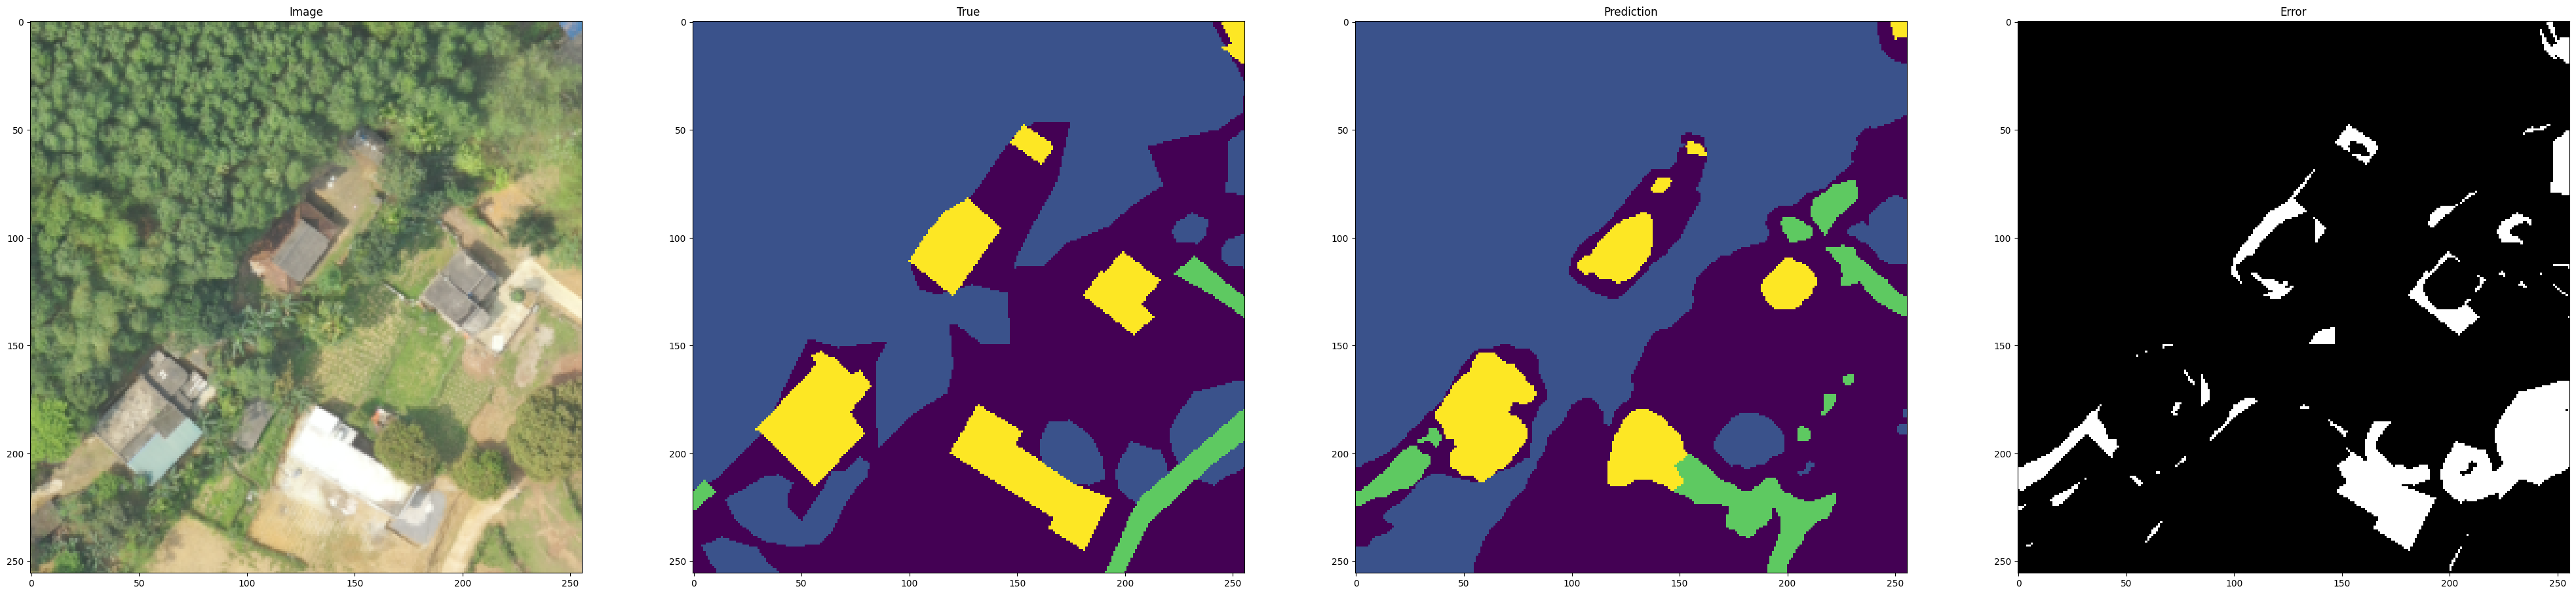

In [11]:
vmin = 0
vmax = 4

for i in range(4):

    image_number = random.randint(0, X_test.shape[0] - 1)

    plt.figure(figsize=(50, 12.5))

    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])

    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)

    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)  # convert to 0-5 classes

    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype('uint8')
    plt.imshow(error, cmap='gray')


In [12]:
# prediction = model.predict(np.expand_dims(X_test[1], 0))
# print(prediction.shape)
# print(prediction)

In [13]:
X_pred = []
X_label = []
for i in range(len(X_test)):
  true = y_test[i].argmax(axis=2)
  prediction = model.predict(np.expand_dims(X_test[i], 0))[0].argmax(axis=2)
  X_pred.append(prediction)
  X_label.append(true)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 41ms/step


In [14]:
X_label = np.array(X_label)
X_pred = np.array(X_pred)

In [15]:
def calculate_iou(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = []

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores.append(0.0)  # Handle the case of no instances of a class
        else:
            iou_scores.append(intersection / union)

    return np.mean(iou_scores)

In [16]:
def calculate_iou_for_each_class(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = {}

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores[class_id] = 0.0  # Handle the case of no instances of a class
        else:
            iou_scores[class_id] = intersection / union

    return iou_scores


iou_scores = calculate_iou_for_each_class(X_label, X_pred)
for class_id, iou in iou_scores.items():
    print("IoU for class", class_id, ":", iou)


IoU for class 0 : 0.8180234192713643
IoU for class 1 : 0.8476291567238635
IoU for class 2 : 0.871902341157304
IoU for class 3 : 0.435177711908513
IoU for class 4 : 0.6203743660187128


In [17]:
miou = calculate_iou(X_label, X_pred)
print("Mean IoU:", miou)

Mean IoU: 0.7186213990159515
